## Analysis of recommenders

In [1]:
from Utils.Dataset import Dataset

dataset = Dataset(path='./Data', validation_percentage=0, test_percentage=0.2)
stacked_URM, _ = dataset.stack_URM_ICM(dataset.URM_train, ICM)

C:\Users\Martim\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(dataset.URM_train).indptr)
profile_length, profile_length.shape

(array([140, 496, 113, ..., 200, 151, 253], dtype=int32), (13650,))

In [3]:
block_size = int(len(profile_length)*0.05)
block_size

682

In [4]:
sorted_users = np.argsort(profile_length)
sorted_users

array([11326,  3075,   758, ...,  1141,  8526,   317], dtype=int64)

In [5]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 682, average p.len 32.44, median 33.0, min 5, max 54
Group 1, #users in group 682, average p.len 73.46, median 74.0, min 54, max 90
Group 2, #users in group 682, average p.len 104.72, median 105.0, min 90, max 119
Group 3, #users in group 682, average p.len 131.64, median 132.0, min 119, max 143
Group 4, #users in group 682, average p.len 154.55, median 155.0, min 143, max 165
Group 5, #users in group 682, average p.len 174.99, median 175.0, min 165, max 184
Group 6, #users in group 682, average p.len 195.77, median 196.0, min 184, max 206
Group 7, #users in group 682, average p.len 217.15, median 217.0, min 206, max 229
Group 8, #users in group 682, average p.len 240.02, median 240.0, min 229, max 251
Group 9, #users in group 682, average p.len 261.59, median 262.0, min 251, max 272
Group 10, #users in group 682, average p.len 282.83, median 283.0, min 272, max 295
Group 11, #users in group 682, average p.len 306.62, median 307.0, min 295, max 318
Group 12, #u

In [6]:
# Base
from Recommenders.Base.TopPop import TopPop

# CF
from Recommenders.CF.KNN.ItemKNNCF import ItemKNNCF
from Recommenders.CF.KNN.UserKNNCF import UserKNNCF
from Recommenders.CF.KNN.RP3beta import RP3beta
from Recommenders.CF.KNN.P3alpha import P3alpha
from Recommenders.CF.KNN.EASE_R import EASE_R
from Recommenders.CF.KNN.SLIM_BPR import SLIM_BPR
from Recommenders.CF.KNN.SLIMElasticNet import SLIMElasticNet
from Recommenders.CF.MatrixFactorization.PureSVD import PureSVD, ScaledPureSVD
from Recommenders.CF.MatrixFactorization.PureSVDItem import PureSVDItem
from Recommenders.CF.MatrixFactorization.IALS import IALS
from Recommenders.CF.LightFM import LightFM
from Recommenders.CF.MultVAE import MultVAE

# CB
from Recommenders.CB.KNN.ItemKNNCBF import ItemKNNCBF

# Hybrid 
from Recommenders.Hybrid.ItemKNN_CFCBF_Hybrid import ItemKNN_CFCBF_Hybrid
from Recommenders.Hybrid.Hybrid1 import Hybrid1
from Recommenders.Hybrid.Hybrid2 import Hybrid2

from Recommenders.CF.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython,\
    MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython

C:\Users\Martim\AppData\Local\Programs\Python\Python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [9]:
from Utils.import_recommenders import *

MAP_recommender_per_group = {}

collaborative_recommender_class = {
    'TopPop': TopPop,
    'ItemKNNCF': ItemKNNCF,
    'UserKNNCF': UserKNNCF,
    'RP3beta': RP3beta,
    'P3alpha': P3alpha,
    'EASE_R': EASE_R,
    #'SLIM_BPR': SLIM_BPR,
    'PureSVD': PureSVD,
    'ScaledPureSVD': ScaledPureSVD,
    'PureSVDItem': PureSVDItem,
    }

hybrid_recommender_class = {
    'ItemKNN_CFCBF_Hybrid': ItemKNN_CFCBF_Hybrid,
}

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(stacked_URM)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object

for label, recommender_class in hybrid_recommender_class.items():
    recommender_object = recommender_class(stacked_URM, dataset.ICM)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object

Similarity column 18059 (100.0%), 1206.83 column/sec. Elapsed time 14.96 sec
Similarity column 13876 (100.0%), 535.36 column/sec. Elapsed time 25.92 sec
EASE_R: Fitting model... 
Similarity column 18059 (100.0%), 839.33 column/sec. Elapsed time 21.52 sec
EASE_R: Fitting model... done in 2.96 min
PureSVD: Computing SVD decomposition...
PureSVD: Computing SVD decomposition... done in 1.27 sec
PureSVDItem: Computing SVD decomposition...
PureSVDItem: Computing SVD decomposition... Done!
Similarity column 18059 (100.0%), 1375.58 column/sec. Elapsed time 13.13 sec


In [11]:
from Utils.Evaluator import EvaluatorHoldout

for group_id in range(0, 20):
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    users_in_group = sorted_users[start_pos:end_pos]
    users_in_group_p_len = profile_length[users_in_group]
    
    print('Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}'.format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(dataset.URM_test, cutoff_list=[10], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[10]['MAP'])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[10]['MAP']]
        

Group 0, #users in group 682, average p.len 32.44, median 33.0, min 5, max 54Deallocating Cython objects

EvaluatorHoldout: Ignoring 13644 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 676 (100.0%) in 1.76 sec. Users per second: 385
EvaluatorHoldout: Processed 676 (100.0%) in 1.63 sec. Users per second: 415
EvaluatorHoldout: Processed 676 (100.0%) in 1.71 sec. Users per second: 396
EvaluatorHoldout: Processed 676 (100.0%) in 1.86 sec. Users per second: 364
EvaluatorHoldout: Processed 676 (100.0%) in 2.14 sec. Users per second: 315
EvaluatorHoldout: Processed 676 (100.0%) in 1.68 sec. Users per second: 403
EvaluatorHoldout: Processed 676 (100.0%) in 1.83 sec. Users per second: 370
EvaluatorHoldout: Processed 676 (100.0%) in 1.56 sec. Users per second: 432
EvaluatorHoldout: Processed 676 (100.0%) in 1.97 sec. Users per second: 343
EvaluatorHoldout: Processed 676 (100.0%) in 1.47 sec. Users per second: 461
Group 1,

c:\Users\Martim\Desktop\recommender-system\Utils\metrics.py:425: RuntimeWarning: invalid value encountered in true_divide
  gini_diversity = 2*np.sum((n_items + 1 - index)/(n_items+1) * recommended_counter_sorted/np.sum(recommended_counter_sorted))


EvaluatorHoldout: Processed 682 (100.0%) in 1.58 sec. Users per second: 432
EvaluatorHoldout: Processed 682 (100.0%) in 1.95 sec. Users per second: 349
EvaluatorHoldout: Processed 682 (100.0%) in 2.02 sec. Users per second: 337
EvaluatorHoldout: Processed 682 (100.0%) in 1.70 sec. Users per second: 402
EvaluatorHoldout: Processed 682 (100.0%) in 2.65 sec. Users per second: 258
EvaluatorHoldout: Processed 682 (100.0%) in 1.77 sec. Users per second: 386
EvaluatorHoldout: Processed 682 (100.0%) in 2.42 sec. Users per second: 282
EvaluatorHoldout: Processed 682 (100.0%) in 1.60 sec. Users per second: 426
Group 6, #users in group 682, average p.len 195.77, median 196.0, min 184, max 206
EvaluatorHoldout: Ignoring 13644 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 682 (100.0%) in 1.60 sec. Users per second: 427
EvaluatorHoldout: Processed 682 (100.0%) in 1.52 sec. Users per second: 450
EvaluatorHoldout: Processed 682

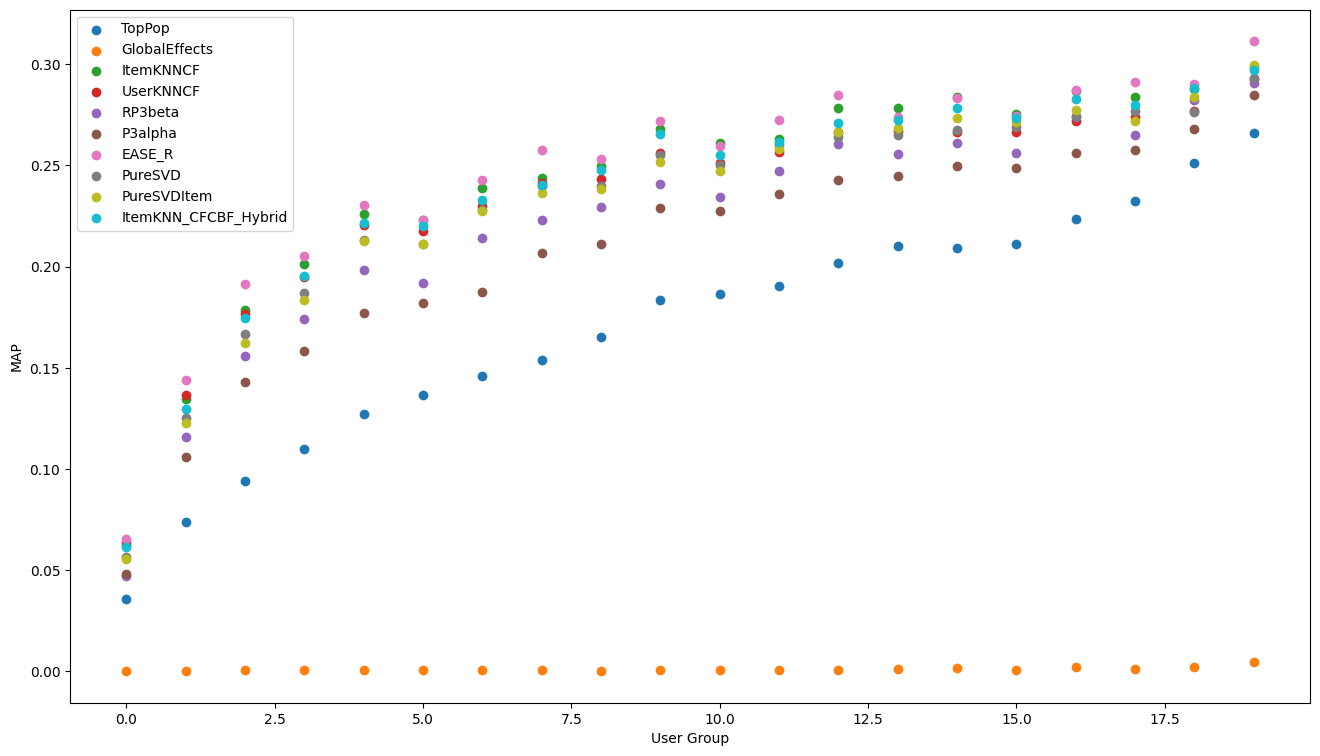

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()